In [1]:
# Character recognizer (Capitals) A to Z

In [2]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# data source : https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format?rvi=1
PATH = 'data/A_Z Handwritten Data.csv'
df = pd.read_csv(PATH).astype('float32')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB


In [83]:
alphabet_map = {i: chr(ord('A') + i) for i in range(26)}
alphabet_map

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
X, y = df.iloc[:,1:], df.iloc[:,0]
X = X.to_numpy()
y = y.to_numpy()
y

array([ 0.,  0.,  0., ..., 25., 25., 25.], dtype=float32)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

In [57]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(335205, 784) (37245, 784) (335205,) (37245,)


In [120]:
[(alphabet_map[i], np.count_nonzero(y_train == i), np.count_nonzero(y_test == i)) for i in alphabet_map]

[('A', 12482, 1387),
 ('B', 7801, 867),
 ('C', 21068, 2341),
 ('D', 9121, 1013),
 ('E', 10296, 1144),
 ('F', 1047, 116),
 ('G', 5186, 576),
 ('H', 6496, 722),
 ('I', 1008, 112),
 ('J', 7644, 849),
 ('K', 5043, 560),
 ('L', 10427, 1159),
 ('M', 11102, 1234),
 ('N', 17109, 1901),
 ('O', 52042, 5783),
 ('P', 17407, 1934),
 ('Q', 5231, 581),
 ('R', 10409, 1157),
 ('S', 43577, 4842),
 ('T', 20246, 2249),
 ('U', 26107, 2901),
 ('V', 3764, 418),
 ('W', 9706, 1078),
 ('X', 5645, 627),
 ('Y', 9773, 1086),
 ('Z', 5468, 608)]

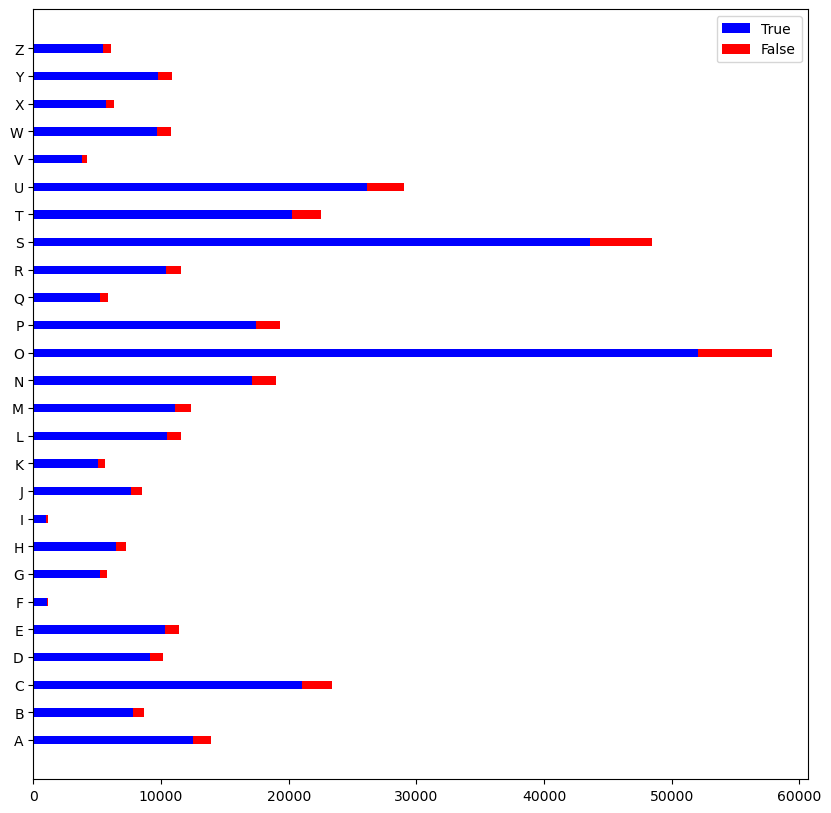

In [119]:
labels = list(alphabet_map.values())
np.count_nonzero(y_train == 9)
train_size, test_size = [], []
[(train_size.append((np.count_nonzero(y_train == i))), test_size.append((np.count_nonzero(y_test == i)))) for i in alphabet_map]

plt.figure(figsize=(10,10))
plt.barh(y=labels, width=train_size, color="blue", height=0.3)
plt.barh(y=labels, width=test_size, left=train_size, color="red", height=0.3)
plt.legend(['True', 'False'], loc='upper right')
plt.show()

In [45]:
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device).type(torch.uint8)
y

tensor([ 0,  0,  0,  ..., 25, 25, 25], device='cuda:0', dtype=torch.uint8)

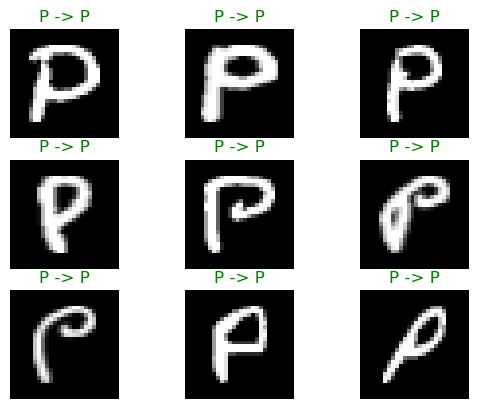

In [35]:
def show_img(X: torch.Tensor, y: torch.Tensor, pred: torch.Tensor):
    X = torch.Tensor.cpu(X).reshape(-1, 28, 28, 1)
    y = torch.Tensor.cpu(y).reshape(-1, 1)
    pred = torch.Tensor.cpu(pred).reshape(-1, 1)
    rows = columns = math.ceil(X.size(dim=0)**0.5)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.size(dim=0)):
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(X[i] , cmap='grey')
        plt.title(f'{alphabet_map[y[i].item()]} -> {alphabet_map[pred[i].item()]}', color=('red' if y[i].item()!=pred[i].item() else 'green'))
    plt.show()

sample_index = 200000
sample_size = 9
show_img(X[sample_index:sample_index+sample_size], y[sample_index:sample_index+sample_size], y[sample_index:sample_index+sample_size])

In [37]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 26)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1
        
        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16
        
        output = output.view(-1, 16 * 4*4) # flattening
        # size = X * 256

        output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [40]:
epochs = 1
learning_rate = 0.0005
model = Model(4*4*16, 120, 80).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
for i in range(epochs):
    pred = model(X_train)
    loss = criterion(pred, y_train)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(i % (epochs//10)==0):
        with torch.no_grad():
            pred_test = model(X_test)
            pred_test = torch.argmax(pred_test, dim=1)
        
            correct = (pred_test==y_test).sum().item()
            acc = 100 * (correct/y_test.size(dim=0))
            print(f'epoch = {i}/{epochs}')
            print(f'loss = {loss.item():.3f}')
            print(f'accuracy = {acc:.3f}', end=2*'\n')


with torch.no_grad(): # not using evaluation(test) for gradient descent
    pred_test = model(X_test)
    pred_test = torch.argmax(pred_test, dim=1)

    correct = (pred_test==y_test).sum().item()
    acc = 100 * (correct/y_test.size(dim=0))
    print(f'epoch = {i+1}/{epochs}')
    print(f'loss = {loss.item():.3f}')
    print(f'accuracy = {acc:.3f}', end=2*'\n')
    
end_time = time.time()
print(f'total {end_time-start_time:.3f} seconds on {device}.')


NameError: name 'X_train' is not defined